## Time series task typology

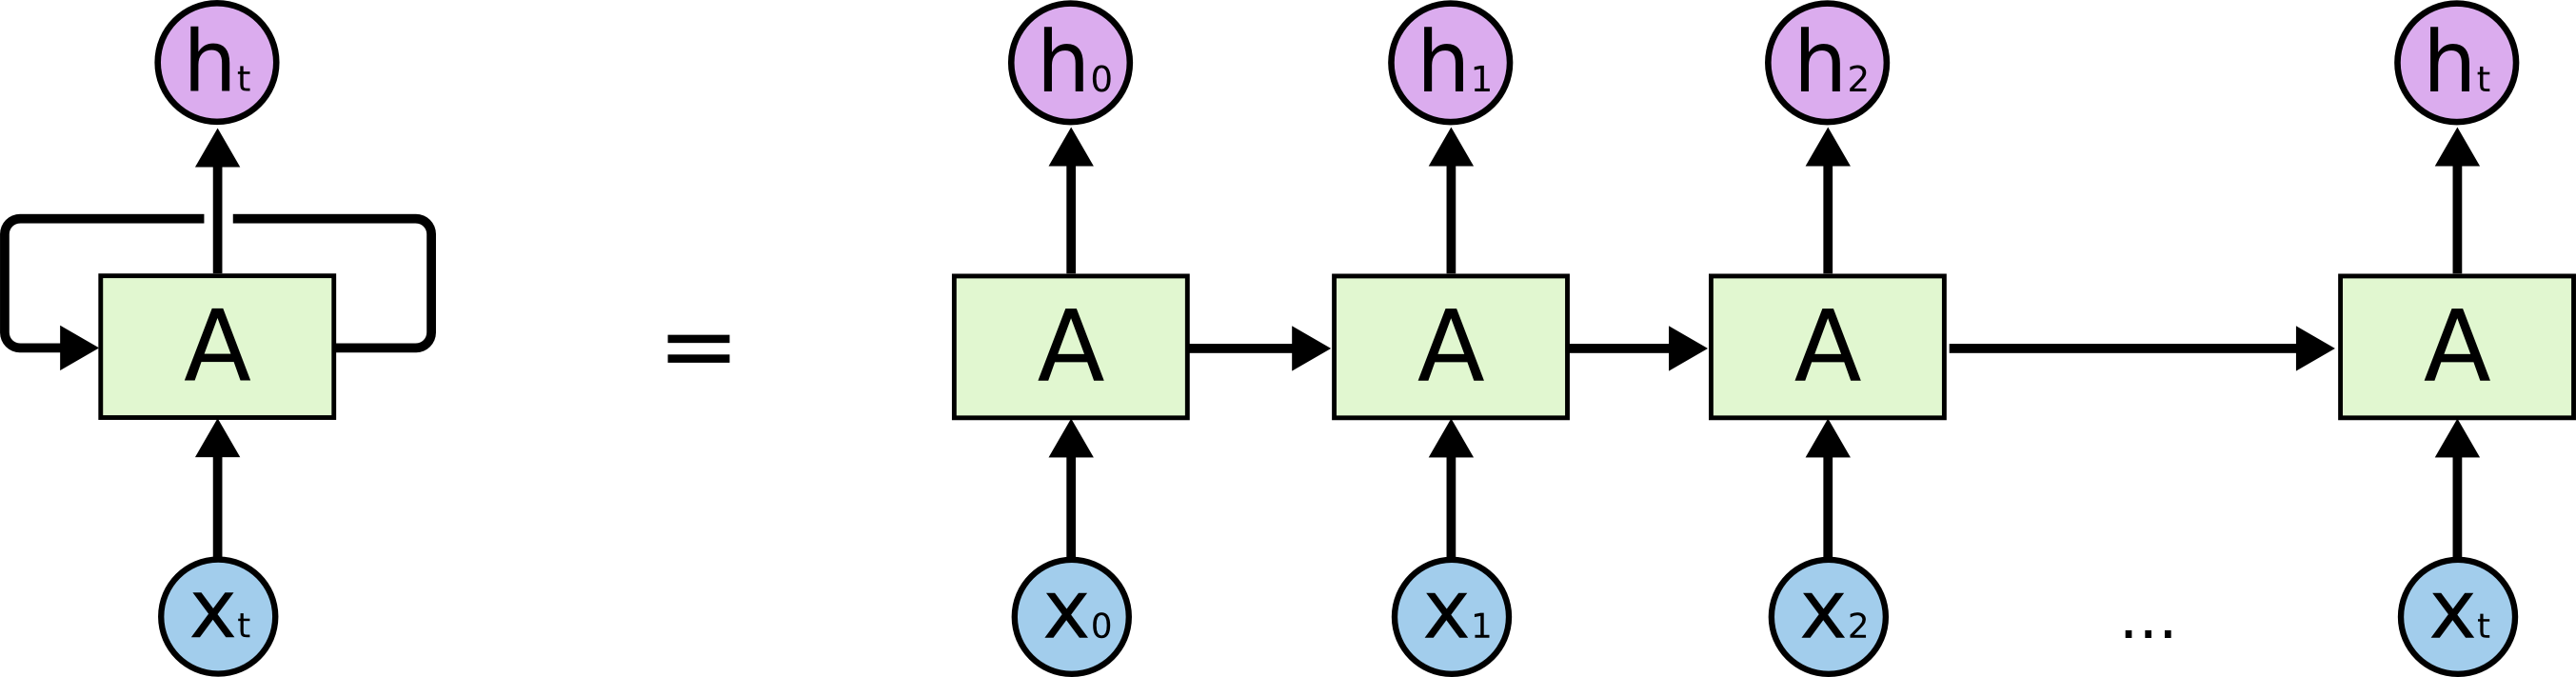

In [1]:
from IPython.display import Image
Image(filename='imgs/RNN-unrolled.png', width=800)

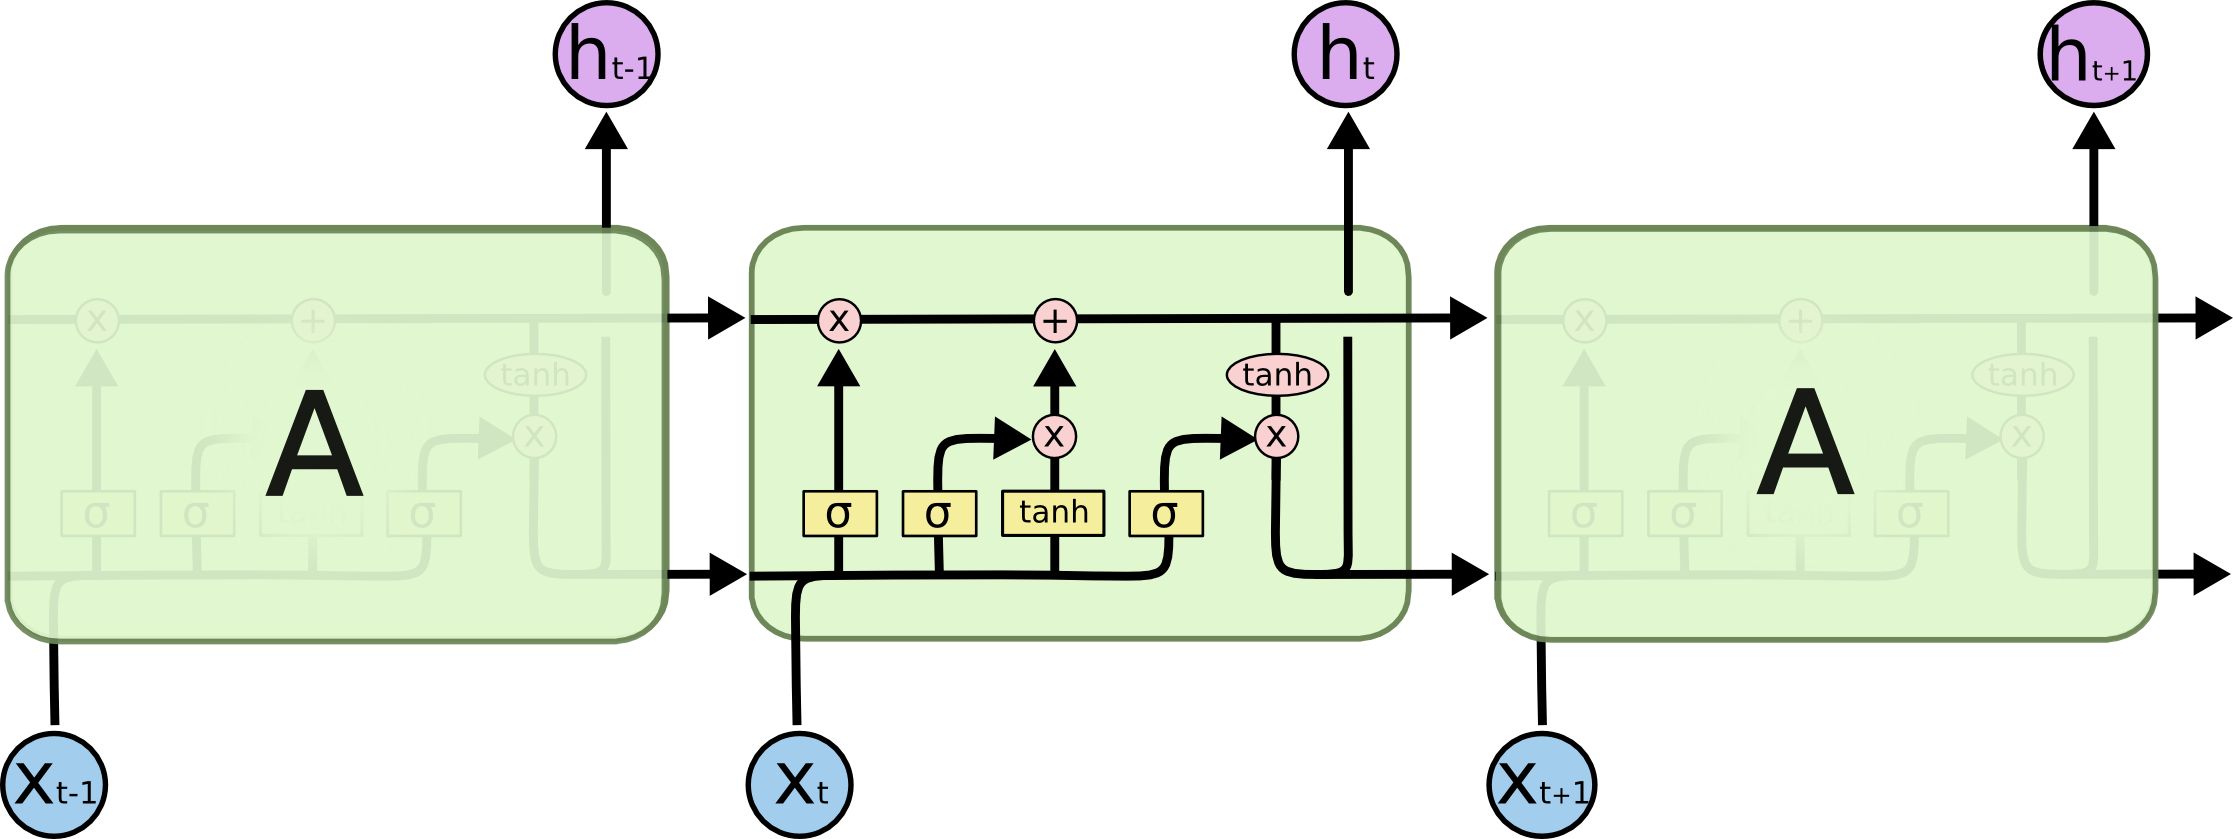

In [2]:
Image(filename='imgs/LSTM3-chain.png', width=800)

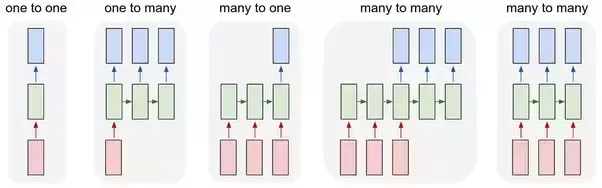

In [3]:
from IPython.display import Image
Image(filename='imgs/lstm-types.jpg', width=800)

- Each rectangle is a vector 
-  arrows represent functions (e.g. matrix multiply). 
- Input vectors are in red
- Output vectors are in blue
- Green vectors hold the RNN's state (more on this soon). 

### **Input data**

must **always** be of shape `[nb_samples, nb_timesteps_in, nb_features_in]`

- if `nb_features`>1 then we are dealing about multisignal time series

### Task typology

**one-to-one**: From fixed-sized input to fixed-sized output (e.g. image classification).
- **input_data**: `[nb_samples, 1, nb_features_in]`
- **output_data**: `[nb_samples, nb_features_out]`

**one-to-many**: Sequence output (e.g. image captioning takes an iFage and outputs a sentence of words). 
- **input_data**: `[nb_samples, 1, nb_features_in]`
- **output_data**: `[nb_samples, nb_timesteps_out, nb_features_out]`

**many-to-one**: Sequence input (e.g. sentiment analysis where a given sentence is classified as expressing positive or negative sentiment).
- **input_data**: `[nb_samples, nb_timesteps_in, nb_features_in]`
- **output_data**: `[nb_samples, nb_features_out]`

**many-to-many**: Sequence input and sequence output (e.g. Machine Translation: an RNN reads a sentence in English and then outputs a sentence in French). 
- **input_data**: `[nb_samples, nb_timesteps_in, nb_features_in]`
- **output_data**: `[nb_samples, nb_timesteps_out, nb_features_out]`

**many-to-many**: Synced sequence input and output (e.g. video classification where we wish to label each frame of the video). Notice that in every case are no pre-specified constraints on the lengths sequences because the recurrent transformation (green) is fixed and can be applied as many times as we like.
- **input_data**: `[nb_samples, nb_timesteps_in, nb_features_in]`
- **output_data**: `[nb_samples, nb_timesteps_out, nb_features_out]`



## Original signal

1.13.1


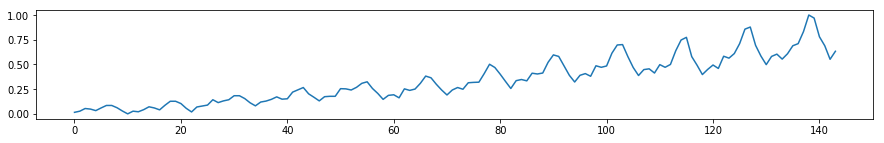

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed, Activation, RepeatVector
import tensorflow as tf
print (tf.__version__)
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

dataset = pd.read_csv('data/international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataset.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

plt.figure(figsize=(15,2))
plt.plot(dataset)




## Timeseries dataset creation

In [5]:
def timeseries_as_one2one(t, timelag=1):
    assert timelag>0, "timelag must be >0"
    X = t[:-timelag].reshape(-1,1,1)
    y = t[timelag:].reshape(-1,1)
    return X,y

def timeseries_as_many2one(t, nb_timesteps_in, timelag=1):
    assert timelag>0, "timelag must be >0"
    X,y = [], []
    for i in range(len(t)-nb_timesteps_in-timelag):
        X.append(t[i:i+nb_timesteps_in])
        y.append(t[i+nb_timesteps_in+timelag-1])
    return np.r_[X].reshape(-1, nb_timesteps_in, 1), np.r_[y].reshape(-1,1)

def timeseries_as_many2many(t, nb_timesteps_in, nb_timesteps_out, timelag=1):
    assert timelag>0, "timelag must be >0"
    X,y = [], []
    for i in range(len(t)-nb_timesteps_in-timelag-nb_timesteps_out):
        X.append(t[i:i+nb_timesteps_in])
        y.append(t[i+nb_timesteps_in+timelag-1:i+nb_timesteps_in+timelag-1+nb_timesteps_out])

    return np.r_[X].reshape(-1, nb_timesteps_in, 1), np.r_[y].reshape(-1,nb_timesteps_out,1)


### one2one

In [6]:
X,y = timeseries_as_one2one(dataset, timelag=1)
print ("Xy shapes", X.shape, y.shape)
print ("original signal", dataset[:10].flatten())
print ("input data")
for i in range(3):
    print (X[i].flatten())
print ("output data", y[:3].flatten())

Xy shapes (143, 1, 1) (143, 1)
original signal [0.01544401 0.02702703 0.05405405 0.04826255 0.03281853 0.05984557
 0.08494207 0.08494207 0.06177607 0.02895753]
input data
[0.01544401]
[0.02702703]
[0.05405405]
output data [0.02702703 0.05405405 0.04826255]


### many2one

In [7]:
X,y = timeseries_as_many2one(dataset, nb_timesteps_in=4, timelag=1)
print ("Xy shapes", X.shape, y.shape)
print ("original signal", dataset[:10].flatten())
print ("input data")
for i in range(3):
    print (X[i].flatten())
print ("output data", y[:3].flatten())

Xy shapes (139, 4, 1) (139, 1)
original signal [0.01544401 0.02702703 0.05405405 0.04826255 0.03281853 0.05984557
 0.08494207 0.08494207 0.06177607 0.02895753]
input data
[0.01544401 0.02702703 0.05405405 0.04826255]
[0.02702703 0.05405405 0.04826255 0.03281853]
[0.05405405 0.04826255 0.03281853 0.05984557]
output data [0.03281853 0.05984557 0.08494207]


### many2many

In [8]:
X,y = timeseries_as_many2many(dataset, nb_timesteps_in=4, nb_timesteps_out=2, timelag=1)
print ("Xy shapes", X.shape, y.shape)
print ("original signal", dataset[:10].flatten())
print ("input data")
for i in range(3):
    print (X[i].flatten())
print ("output data")
for i in range(3):
    print (y[i].flatten())


Xy shapes (137, 4, 1) (137, 2, 1)
original signal [0.01544401 0.02702703 0.05405405 0.04826255 0.03281853 0.05984557
 0.08494207 0.08494207 0.06177607 0.02895753]
input data
[0.01544401 0.02702703 0.05405405 0.04826255]
[0.02702703 0.05405405 0.04826255 0.03281853]
[0.05405405 0.04826255 0.03281853 0.05984557]
output data
[0.03281853 0.05984557]
[0.05984557 0.08494207]
[0.08494207 0.08494207]


# LSTMs

## for one2one

In [9]:
X,y = timeseries_as_one2one(dataset, timelag=1)
X.shape, y.shape

((143, 1, 1), (143, 1))

In [10]:
i = int(len(X)*2./3)
Xtr, ytr = X[:i], y[:i]
Xts, yts = X[i:], y[i:]
Xtr.shape, Xts.shape, ytr.shape, yts.shape

((95, 1, 1), (48, 1, 1), (95, 1), (48, 1))

In [11]:
def get_one2one_single_layer_LSTM(n_neurons):
    # create LSTM
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(LSTM(n_neurons, input_shape=(1, 1), recurrent_activation="sigmoid"))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=["mape"])
    return model

In [12]:
model = get_one2one_single_layer_LSTM(n_neurons=10)
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10)                480       
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
model.fit(Xtr, ytr, epochs=150, batch_size=10, verbose=1, validation_data=(Xts, yts))

Train on 95 samples, validate on 48 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/150
95/95 [==============================] - 1s 10ms/sample - loss: 0.0476 - mean_absolute_percentage_error: 76416.9062 - val_loss: 0.2716 - val_mean_absolute_percentage_error: 83.9118
Epoch 2/150
95/95 [==============================] - 0s 511us/sample - loss: 0.0394 - mean_absolute_percentage_error: 335200.4688 - val_loss: 0.2429 - val_mean_absolute_percentage_error: 78.8758
Epoch 3/150
95/95 [==============================] - 0s 409us/sample - loss: 0.0324 - mean_absolute_percentage_error: 545687.0000 - val_loss: 0.2163 - val_mean_absolute_percentage_error: 73.9235
Epoch 4/150
95/95 [==============================] - 0s 416us/sample - loss: 0.0263 - mean_absolute_percentage_error: 842645.8750 - val_loss: 0.1918 - val_mean_absolute_percentage_error: 69.0854
Epoch 5/150
95/95 [==============================] - 0s 459us/sample - loss: 0.0215 - mean_absolute_percentage_error: 938943.7500 

95/95 [==============================] - 0s 330us/sample - loss: 0.0042 - mean_absolute_percentage_error: 1187519.5000 - val_loss: 0.0248 - val_mean_absolute_percentage_error: 20.5270
Epoch 42/150
95/95 [==============================] - 0s 354us/sample - loss: 0.0040 - mean_absolute_percentage_error: 1172835.8750 - val_loss: 0.0234 - val_mean_absolute_percentage_error: 19.7907
Epoch 43/150
95/95 [==============================] - 0s 374us/sample - loss: 0.0038 - mean_absolute_percentage_error: 1118281.6250 - val_loss: 0.0228 - val_mean_absolute_percentage_error: 19.4902
Epoch 44/150
95/95 [==============================] - 0s 339us/sample - loss: 0.0037 - mean_absolute_percentage_error: 1102232.5000 - val_loss: 0.0217 - val_mean_absolute_percentage_error: 18.8609
Epoch 45/150
95/95 [==============================] - 0s 322us/sample - loss: 0.0035 - mean_absolute_percentage_error: 1065375.8750 - val_loss: 0.0205 - val_mean_absolute_percentage_error: 18.2930
Epoch 46/150
95/95 [========

Epoch 83/150
95/95 [==============================] - 0s 424us/sample - loss: 0.0020 - mean_absolute_percentage_error: 563521.6250 - val_loss: 0.0091 - val_mean_absolute_percentage_error: 13.3019
Epoch 84/150
95/95 [==============================] - 0s 441us/sample - loss: 0.0020 - mean_absolute_percentage_error: 551352.1250 - val_loss: 0.0091 - val_mean_absolute_percentage_error: 13.3263
Epoch 85/150
95/95 [==============================] - 0s 516us/sample - loss: 0.0020 - mean_absolute_percentage_error: 561194.0625 - val_loss: 0.0091 - val_mean_absolute_percentage_error: 13.2868
Epoch 86/150
95/95 [==============================] - 0s 409us/sample - loss: 0.0020 - mean_absolute_percentage_error: 566702.0625 - val_loss: 0.0091 - val_mean_absolute_percentage_error: 13.2465
Epoch 87/150
95/95 [==============================] - 0s 489us/sample - loss: 0.0020 - mean_absolute_percentage_error: 579465.3750 - val_loss: 0.0091 - val_mean_absolute_percentage_error: 13.2748
Epoch 88/150
95/95 [

Epoch 125/150
95/95 [==============================] - 0s 448us/sample - loss: 0.0020 - mean_absolute_percentage_error: 509407.8750 - val_loss: 0.0091 - val_mean_absolute_percentage_error: 13.3028
Epoch 126/150
95/95 [==============================] - 0s 443us/sample - loss: 0.0020 - mean_absolute_percentage_error: 545257.9375 - val_loss: 0.0091 - val_mean_absolute_percentage_error: 13.2261
Epoch 127/150
95/95 [==============================] - 0s 394us/sample - loss: 0.0020 - mean_absolute_percentage_error: 550979.3125 - val_loss: 0.0091 - val_mean_absolute_percentage_error: 13.2346
Epoch 128/150
95/95 [==============================] - 0s 369us/sample - loss: 0.0020 - mean_absolute_percentage_error: 513760.3750 - val_loss: 0.0091 - val_mean_absolute_percentage_error: 13.2968
Epoch 129/150
95/95 [==============================] - 0s 384us/sample - loss: 0.0020 - mean_absolute_percentage_error: 499803.7812 - val_loss: 0.0091 - val_mean_absolute_percentage_error: 13.3017
Epoch 130/150
9

In [14]:
yts_preds = model.predict(Xts)
print ("trend accuracy %.2f"%(np.mean( (yts_preds[1:]>yts_preds[:-1])==(yts[1:]>yts[:-1]))))
yts_preds.shape

trend accuracy 0.53


(48, 1)

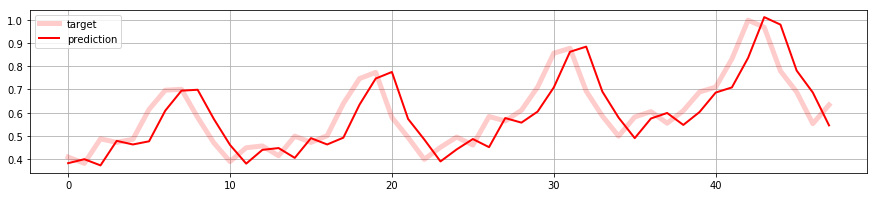

In [15]:
plt.figure(figsize=(15,3))
plt.plot(yts[:,0], color="red", alpha=.2, lw=5, label="target")
plt.plot(yts_preds[:,0], color="red", alpha=1, lw=2, label="prediction")
plt.legend()
plt.grid()

## For many2one

In [16]:
X,y = timeseries_as_many2one(dataset, nb_timesteps_in=20, timelag=1)
X.shape, y.shape

((123, 20, 1), (123, 1))

In [17]:
i = int(len(X)*2./3)
Xtr, ytr = X[:i], y[:i]
Xts, yts = X[i:], y[i:]
Xtr.shape, Xts.shape, ytr.shape, yts.shape

((82, 20, 1), (41, 20, 1), (82, 1), (41, 1))

In [18]:
def get_many2one_single_layer_LSTM(n_neurons, nb_timesteps_in):
    # create LSTM
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(LSTM(n_neurons, input_shape=(nb_timesteps_in, 1),recurrent_activation="sigmoid"))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=["mape"])
    return model

In [19]:
model = get_many2one_single_layer_LSTM(n_neurons=30, nb_timesteps_in=X.shape[1])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30)                3840      
_________________________________________________________________
dense (Dense)                (None, 1)                 31        
Total params: 3,871
Trainable params: 3,871
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
model.fit(Xtr, ytr, epochs=150, batch_size=10, verbose=1, validation_data=(Xts, yts))

Train on 82 samples, validate on 41 samples
Epoch 1/150
82/82 [==============================] - 1s 7ms/sample - loss: 0.0298 - mean_absolute_percentage_error: 46.6853 - val_loss: 0.0468 - val_mean_absolute_percentage_error: 23.9976
Epoch 2/150
82/82 [==============================] - 0s 2ms/sample - loss: 0.0089 - mean_absolute_percentage_error: 50.0129 - val_loss: 0.0200 - val_mean_absolute_percentage_error: 20.1748
Epoch 3/150
82/82 [==============================] - 0s 1ms/sample - loss: 0.0076 - mean_absolute_percentage_error: 48.5079 - val_loss: 0.0327 - val_mean_absolute_percentage_error: 19.1269
Epoch 4/150
82/82 [==============================] - 0s 2ms/sample - loss: 0.0064 - mean_absolute_percentage_error: 31.1086 - val_loss: 0.0383 - val_mean_absolute_percentage_error: 21.0255
Epoch 5/150
82/82 [==============================] - 0s 1ms/sample - loss: 0.0058 - mean_absolute_percentage_error: 30.9410 - val_loss: 0.0246 - val_mean_absolute_percentage_error: 17.6563
Epoch 6/150

Epoch 44/150
82/82 [==============================] - 0s 2ms/sample - loss: 0.0039 - mean_absolute_percentage_error: 22.1190 - val_loss: 0.0140 - val_mean_absolute_percentage_error: 16.5503
Epoch 45/150
82/82 [==============================] - 0s 2ms/sample - loss: 0.0043 - mean_absolute_percentage_error: 26.5590 - val_loss: 0.0140 - val_mean_absolute_percentage_error: 17.4676
Epoch 46/150
82/82 [==============================] - 0s 2ms/sample - loss: 0.0036 - mean_absolute_percentage_error: 22.0545 - val_loss: 0.0136 - val_mean_absolute_percentage_error: 14.1752
Epoch 47/150
82/82 [==============================] - 0s 2ms/sample - loss: 0.0037 - mean_absolute_percentage_error: 20.8163 - val_loss: 0.0125 - val_mean_absolute_percentage_error: 16.1651
Epoch 48/150
82/82 [==============================] - 0s 2ms/sample - loss: 0.0034 - mean_absolute_percentage_error: 24.2653 - val_loss: 0.0119 - val_mean_absolute_percentage_error: 16.3279
Epoch 49/150
82/82 [==============================

82/82 [==============================] - 0s 2ms/sample - loss: 0.0016 - mean_absolute_percentage_error: 17.0514 - val_loss: 0.0050 - val_mean_absolute_percentage_error: 10.2313
Epoch 88/150
82/82 [==============================] - 0s 2ms/sample - loss: 0.0018 - mean_absolute_percentage_error: 17.7267 - val_loss: 0.0056 - val_mean_absolute_percentage_error: 10.1135
Epoch 89/150
82/82 [==============================] - 0s 2ms/sample - loss: 0.0018 - mean_absolute_percentage_error: 16.9783 - val_loss: 0.0053 - val_mean_absolute_percentage_error: 10.2574
Epoch 90/150
82/82 [==============================] - 0s 2ms/sample - loss: 0.0022 - mean_absolute_percentage_error: 19.4783 - val_loss: 0.0056 - val_mean_absolute_percentage_error: 10.4656
Epoch 91/150
82/82 [==============================] - 0s 2ms/sample - loss: 0.0020 - mean_absolute_percentage_error: 17.2331 - val_loss: 0.0071 - val_mean_absolute_percentage_error: 10.9960
Epoch 92/150
82/82 [==============================] - 0s 2ms/sa

82/82 [==============================] - 0s 3ms/sample - loss: 0.0016 - mean_absolute_percentage_error: 17.2385 - val_loss: 0.0048 - val_mean_absolute_percentage_error: 9.8205
Epoch 131/150
82/82 [==============================] - 0s 4ms/sample - loss: 0.0017 - mean_absolute_percentage_error: 16.0938 - val_loss: 0.0058 - val_mean_absolute_percentage_error: 9.8094
Epoch 132/150
82/82 [==============================] - 0s 3ms/sample - loss: 0.0016 - mean_absolute_percentage_error: 16.5825 - val_loss: 0.0049 - val_mean_absolute_percentage_error: 10.1830
Epoch 133/150
82/82 [==============================] - 0s 4ms/sample - loss: 0.0017 - mean_absolute_percentage_error: 17.6135 - val_loss: 0.0049 - val_mean_absolute_percentage_error: 9.7908
Epoch 134/150
82/82 [==============================] - 0s 3ms/sample - loss: 0.0016 - mean_absolute_percentage_error: 16.3610 - val_loss: 0.0047 - val_mean_absolute_percentage_error: 10.0164
Epoch 135/150
82/82 [==============================] - 0s 3ms/

In [21]:
yts_preds = model.predict(Xts)
yts_preds.shape
print ("trend accuracy %.2f"%(np.mean( (yts_preds[1:]>yts_preds[:-1])==(yts[1:]>yts[:-1]))))

trend accuracy 0.78


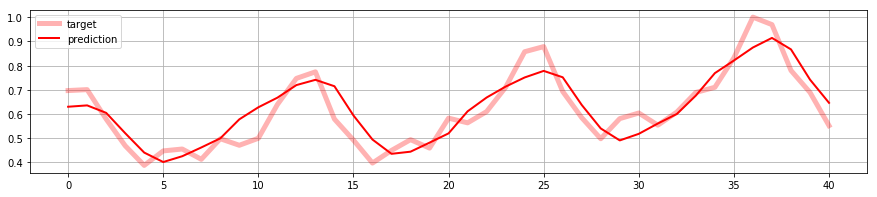

In [22]:
plt.figure(figsize=(15,3))
plt.plot(yts[:,0], color="red", alpha=.3, lw=5, label="target")
plt.plot(yts_preds[:,0], color="red", alpha=1, lw=2, label="prediction")
plt.legend()
plt.grid()

## For many2many

see https://stackoverflow.com/questions/43034960/many-to-one-and-many-to-many-lstm-examples-in-keras

In [23]:
def timeseries_as_many2many(t, nb_timesteps_in, nb_timesteps_out, timelag=1):
    assert timelag>0, "timelag must be >0"
    X,y = [], []
    for i in range(len(t)-nb_timesteps_in-timelag-nb_timesteps_out):
        X.append(t[i:i+nb_timesteps_in])
        y.append(t[i+nb_timesteps_in+timelag-1:i+nb_timesteps_in+timelag-1+nb_timesteps_out])

    return np.r_[X].reshape(-1, nb_timesteps_in, 1), np.r_[y].reshape(-1,nb_timesteps_out,1)




In [24]:
X,y = timeseries_as_many2many(dataset, nb_timesteps_in=30, nb_timesteps_out=5, timelag=1)
X.shape, y.shape

((108, 30, 1), (108, 5, 1))

In [25]:
i = int(len(X)*2./3)
Xtr, ytr = X[:i], y[:i]
Xts, yts = X[i:], y[i:]
Xtr.shape, Xts.shape, ytr.shape, yts.shape

((72, 30, 1), (36, 30, 1), (72, 5, 1), (36, 5, 1))

In [26]:
from tensorflow.keras.optimizers import RMSprop

In [27]:
def get_many2many_single_layer_LSTM(n_neurons1, n_neurons2,  nb_timesteps_in, nb_timesteps_out):
    from tensorflow.keras.optimizers import RMSprop    
    
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(LSTM(n_neurons1, input_shape=(nb_timesteps_in, 1), 
                   recurrent_activation="sigmoid", return_sequences=False))
    model.add(RepeatVector(nb_timesteps_out))
    model.add(LSTM(n_neurons2, input_shape=(nb_timesteps_out, 1), 
                   recurrent_activation="sigmoid", return_sequences=True))
    model.add(Dense(1))
    optimizer = RMSprop(lr=0.0001)
    model.compile(loss='mean_squared_error', optimizer="rmsprop", metrics=["mape"])
    return model

In [28]:
model = get_many2many_single_layer_LSTM(n_neurons1=20, n_neurons2=50,
                                        nb_timesteps_in=X.shape[1], nb_timesteps_out=y.shape[1])
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20)                1760      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 5, 20)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 50)             14200     
_________________________________________________________________
dense (Dense)                (None, 5, 1)              51        
Total params: 16,011
Trainable params: 16,011
Non-trainable params: 0
_________________________________________________________________
None


In [29]:
model.fit(Xtr, ytr, epochs=300, batch_size=10, verbose=1, validation_data=(Xts, yts))

Train on 72 samples, validate on 36 samples
Epoch 1/300
72/72 [==============================] - 2s 25ms/sample - loss: 0.0523 - mean_absolute_percentage_error: 58.6396 - val_loss: 0.0942 - val_mean_absolute_percentage_error: 39.3878
Epoch 2/300
72/72 [==============================] - 0s 3ms/sample - loss: 0.0203 - mean_absolute_percentage_error: 39.5655 - val_loss: 0.0846 - val_mean_absolute_percentage_error: 36.7166
Epoch 3/300
72/72 [==============================] - 0s 3ms/sample - loss: 0.0179 - mean_absolute_percentage_error: 36.3123 - val_loss: 0.0574 - val_mean_absolute_percentage_error: 30.4027
Epoch 4/300
72/72 [==============================] - 0s 3ms/sample - loss: 0.0150 - mean_absolute_percentage_error: 35.1141 - val_loss: 0.0510 - val_mean_absolute_percentage_error: 27.9402
Epoch 5/300
72/72 [==============================] - 0s 3ms/sample - loss: 0.0126 - mean_absolute_percentage_error: 32.4554 - val_loss: 0.0364 - val_mean_absolute_percentage_error: 27.8057
Epoch 6/30

Epoch 44/300
72/72 [==============================] - 0s 3ms/sample - loss: 0.0068 - mean_absolute_percentage_error: 21.3352 - val_loss: 0.0247 - val_mean_absolute_percentage_error: 26.0760
Epoch 45/300
72/72 [==============================] - 0s 3ms/sample - loss: 0.0061 - mean_absolute_percentage_error: 22.2600 - val_loss: 0.0210 - val_mean_absolute_percentage_error: 15.6202
Epoch 46/300
72/72 [==============================] - 0s 3ms/sample - loss: 0.0061 - mean_absolute_percentage_error: 20.8704 - val_loss: 0.0335 - val_mean_absolute_percentage_error: 31.2985
Epoch 47/300
72/72 [==============================] - 0s 3ms/sample - loss: 0.0053 - mean_absolute_percentage_error: 20.7223 - val_loss: 0.0354 - val_mean_absolute_percentage_error: 32.1514
Epoch 48/300
72/72 [==============================] - 0s 3ms/sample - loss: 0.0062 - mean_absolute_percentage_error: 22.5386 - val_loss: 0.0197 - val_mean_absolute_percentage_error: 22.5165
Epoch 49/300
72/72 [==============================

72/72 [==============================] - 0s 4ms/sample - loss: 0.0034 - mean_absolute_percentage_error: 16.8665 - val_loss: 0.0215 - val_mean_absolute_percentage_error: 21.4597
Epoch 88/300
72/72 [==============================] - 0s 4ms/sample - loss: 0.0030 - mean_absolute_percentage_error: 16.4299 - val_loss: 0.0277 - val_mean_absolute_percentage_error: 24.6766
Epoch 89/300
72/72 [==============================] - 0s 4ms/sample - loss: 0.0030 - mean_absolute_percentage_error: 16.3429 - val_loss: 0.0159 - val_mean_absolute_percentage_error: 18.2408
Epoch 90/300
72/72 [==============================] - 0s 4ms/sample - loss: 0.0026 - mean_absolute_percentage_error: 15.9352 - val_loss: 0.0125 - val_mean_absolute_percentage_error: 16.3457
Epoch 91/300
72/72 [==============================] - 0s 4ms/sample - loss: 0.0031 - mean_absolute_percentage_error: 16.7606 - val_loss: 0.0110 - val_mean_absolute_percentage_error: 15.6921
Epoch 92/300
72/72 [==============================] - 0s 4ms/sa

72/72 [==============================] - 0s 4ms/sample - loss: 0.0021 - mean_absolute_percentage_error: 14.5123 - val_loss: 0.0098 - val_mean_absolute_percentage_error: 13.4774
Epoch 131/300
72/72 [==============================] - 0s 4ms/sample - loss: 0.0020 - mean_absolute_percentage_error: 13.9047 - val_loss: 0.0172 - val_mean_absolute_percentage_error: 16.7504
Epoch 132/300
72/72 [==============================] - 0s 4ms/sample - loss: 0.0023 - mean_absolute_percentage_error: 14.6542 - val_loss: 0.0086 - val_mean_absolute_percentage_error: 12.8518
Epoch 133/300
72/72 [==============================] - 0s 4ms/sample - loss: 0.0019 - mean_absolute_percentage_error: 14.0503 - val_loss: 0.0148 - val_mean_absolute_percentage_error: 17.6656
Epoch 134/300
72/72 [==============================] - 0s 3ms/sample - loss: 0.0026 - mean_absolute_percentage_error: 15.3004 - val_loss: 0.0101 - val_mean_absolute_percentage_error: 13.5729
Epoch 135/300
72/72 [==============================] - 0s 3

Epoch 173/300
72/72 [==============================] - 0s 4ms/sample - loss: 0.0018 - mean_absolute_percentage_error: 13.5177 - val_loss: 0.0140 - val_mean_absolute_percentage_error: 14.0879
Epoch 174/300
72/72 [==============================] - 0s 4ms/sample - loss: 0.0020 - mean_absolute_percentage_error: 13.0766 - val_loss: 0.0121 - val_mean_absolute_percentage_error: 13.6251
Epoch 175/300
72/72 [==============================] - 0s 4ms/sample - loss: 0.0017 - mean_absolute_percentage_error: 13.1255 - val_loss: 0.0166 - val_mean_absolute_percentage_error: 18.0612
Epoch 176/300
72/72 [==============================] - 0s 3ms/sample - loss: 0.0021 - mean_absolute_percentage_error: 13.8732 - val_loss: 0.0122 - val_mean_absolute_percentage_error: 15.5505
Epoch 177/300
72/72 [==============================] - 0s 3ms/sample - loss: 0.0019 - mean_absolute_percentage_error: 13.7773 - val_loss: 0.0094 - val_mean_absolute_percentage_error: 12.4925
Epoch 178/300
72/72 [========================

Epoch 216/300
72/72 [==============================] - 0s 3ms/sample - loss: 0.0015 - mean_absolute_percentage_error: 12.0436 - val_loss: 0.0070 - val_mean_absolute_percentage_error: 10.5068
Epoch 217/300
72/72 [==============================] - 0s 4ms/sample - loss: 0.0019 - mean_absolute_percentage_error: 13.7358 - val_loss: 0.0081 - val_mean_absolute_percentage_error: 11.1551
Epoch 218/300
72/72 [==============================] - 0s 3ms/sample - loss: 0.0016 - mean_absolute_percentage_error: 12.6715 - val_loss: 0.0129 - val_mean_absolute_percentage_error: 15.9466
Epoch 219/300
72/72 [==============================] - 0s 3ms/sample - loss: 0.0014 - mean_absolute_percentage_error: 12.1562 - val_loss: 0.0080 - val_mean_absolute_percentage_error: 11.2410
Epoch 220/300
72/72 [==============================] - 0s 3ms/sample - loss: 0.0019 - mean_absolute_percentage_error: 13.9628 - val_loss: 0.0084 - val_mean_absolute_percentage_error: 11.4824
Epoch 221/300
72/72 [========================

Epoch 259/300
72/72 [==============================] - 0s 3ms/sample - loss: 0.0014 - mean_absolute_percentage_error: 11.9467 - val_loss: 0.0069 - val_mean_absolute_percentage_error: 10.0998
Epoch 260/300
72/72 [==============================] - 0s 3ms/sample - loss: 0.0015 - mean_absolute_percentage_error: 12.1896 - val_loss: 0.0110 - val_mean_absolute_percentage_error: 15.8040
Epoch 261/300
72/72 [==============================] - 0s 3ms/sample - loss: 0.0011 - mean_absolute_percentage_error: 11.1365 - val_loss: 0.0069 - val_mean_absolute_percentage_error: 10.1860
Epoch 262/300
72/72 [==============================] - 0s 3ms/sample - loss: 0.0013 - mean_absolute_percentage_error: 11.5720 - val_loss: 0.0157 - val_mean_absolute_percentage_error: 18.7261
Epoch 263/300
72/72 [==============================] - 0s 3ms/sample - loss: 0.0013 - mean_absolute_percentage_error: 11.5246 - val_loss: 0.0082 - val_mean_absolute_percentage_error: 11.5828
Epoch 264/300
72/72 [========================

In [32]:
yts_preds = model.predict(Xts)
print (yts_preds.shape)
ta = np.mean([np.mean((yts_preds[i,1:,0]>yts_preds[i,:-1,0])==(yts[i,1:,0]>yts[i,:-1,0])) for i in range(len(yts))])
print ("trend accuracy %.2f"%ta)

(36, 5, 1)
trend accuracy 0.74


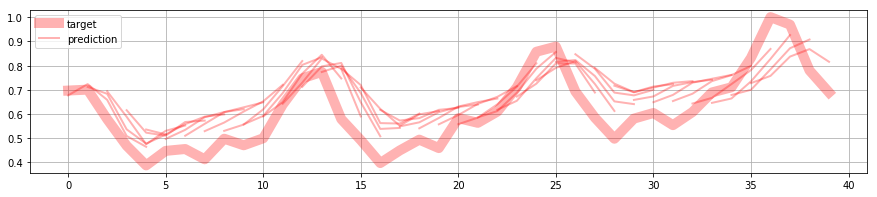

In [33]:
plt.figure(figsize=(15,3))

k = np.r_[[0.]*(yts.shape[0]+yts.shape[1]-1)]
k[:yts.shape[0]] = yts[:,0,0]
k[-yts.shape[1]+1:] = yts[-1,1:,0]
plt.plot(k, color="red", alpha=.3, lw=10, label="target")

for i in range(len(yts_preds)):
    plt.plot(range(i,i+yts.shape[1]), yts_preds[i,:,0], color="red", alpha=.3, lw=2, label="prediction" if i==0 else None)

plt.legend()
plt.grid()